In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline  

from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 42

# 1. Getting familiar with data

In [153]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1459], all_data.loc[1460:]

df_train = pd.read_csv('data/train.csv')
y_train = df_train.SalePrice
id_val = df_train.Id
df_test = pd.read_csv('data/test.csv')
df_all = concat_df(df_train, df_test).drop(['SalePrice', 'Id'], axis=1)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Training y Shape = {df_train["SalePrice"].shape[0]}\n')
print(f'Test X Shape = {df_test.shape}')
print(f'Test y Shape = {df_test.shape[0]}\n')
print(df_train.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 

In [154]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.1 Missing values

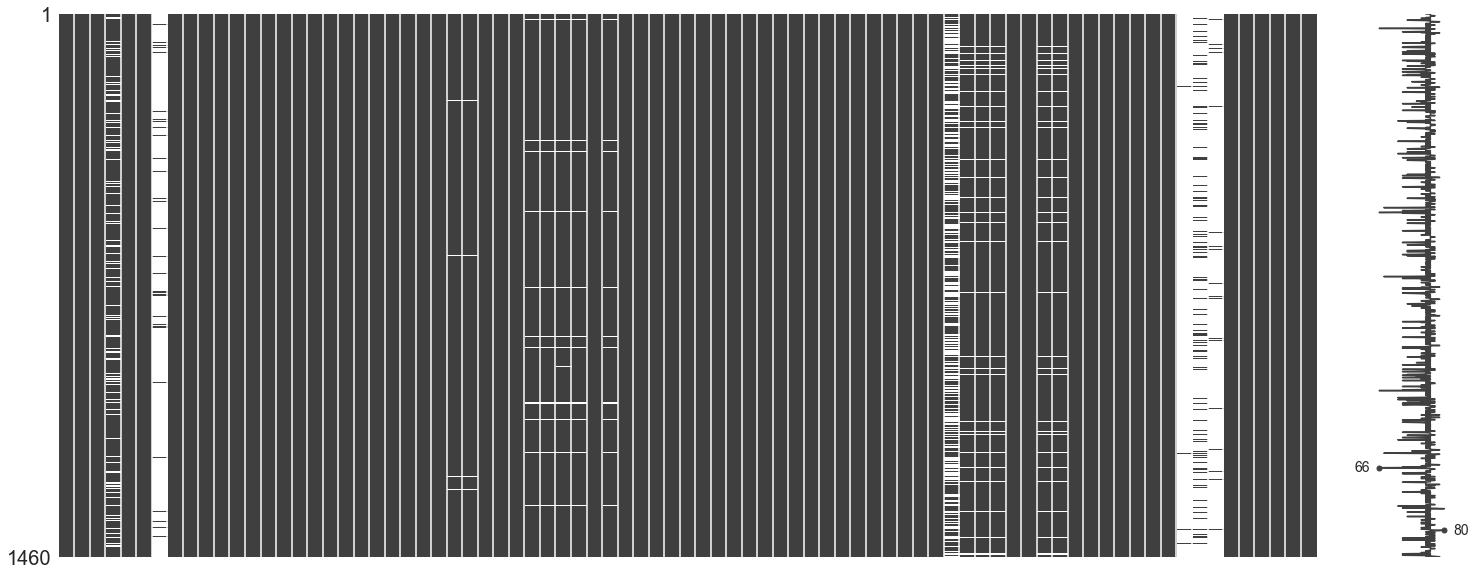

In [155]:
msno.matrix(df_train)
plt.show()

In [156]:
for df in dfs:
    print(f'Only features contained missing value in {df.name}')
    temp = df.isnull().sum()
    print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Set
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 

Only features contained missing value in Test Set
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76

- For features having missing value smaller than 100 -> fill numeric features with the corresponding median & categorical features with the corresponding most frequent values
- For features having missing value larger than 1000 -> remove these features
- For other features having missing value -> fill them with "None" value (b.c all the other features are object features)

In [157]:
null_features = df_all.isnull().sum()

# For features having smaller than 100 missing values
null_100 = df_all.columns[list((null_features < 100) & (null_features != 0))]
num = df_all[null_100].select_dtypes(include=np.number).columns
non_num = df_all[null_100].select_dtypes(include='object').columns
# Numerous features
df_all[num] = df_all[num].apply(lambda x: x.fillna(x.median()))
# Object features
df_all[non_num] = df_all[non_num].apply(lambda x: x.fillna(x.value_counts().index[0]))

# For features having larger than 1000 missing values
null_1000 = df_all.columns[list(null_features > 1000)]
df_all.drop(null_1000, axis=1, inplace=True)
df_all.drop(['GarageYrBlt', 'LotFrontage'], axis=1, inplace=True)

In [158]:
# For other features having missing values
# GarageCond
df_all['GarageCond'] = df_all['GarageCond'].fillna('Null')
# GarageFinish
df_all['GarageFinish'] = df_all['GarageFinish'].fillna('Null')
# GarageQual
df_all['GarageQual'] = df_all['GarageQual'].fillna('Null')
# GarageType
df_all['GarageType'] = df_all['GarageType'].fillna('Null')
# GarageYrBlt
# df_all['GarageYrBlt'] = df_all['GarageYrBlt'].fillna('Null')
# # # LotFrontage
# df_all['LotFrontage'] = df_all['LotFrontage'].fillna('Null')

In [159]:
# Checking existing missing value or not
print(df_all.isnull().any().sum())
df_train, df_test = divide_df(df_all)
df_train = pd.concat([df_train, y_train], axis=1)  # Concatenate for analysis

0


## 1.2 Numeric feature

Finding the correlation between target feature and the other features

In [160]:
# Seeing the correlation between features and target
df_train_corr = df_train.corr()['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
df_train_corr.head()

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

Visualize the 16 features which has the highest correlation with the target

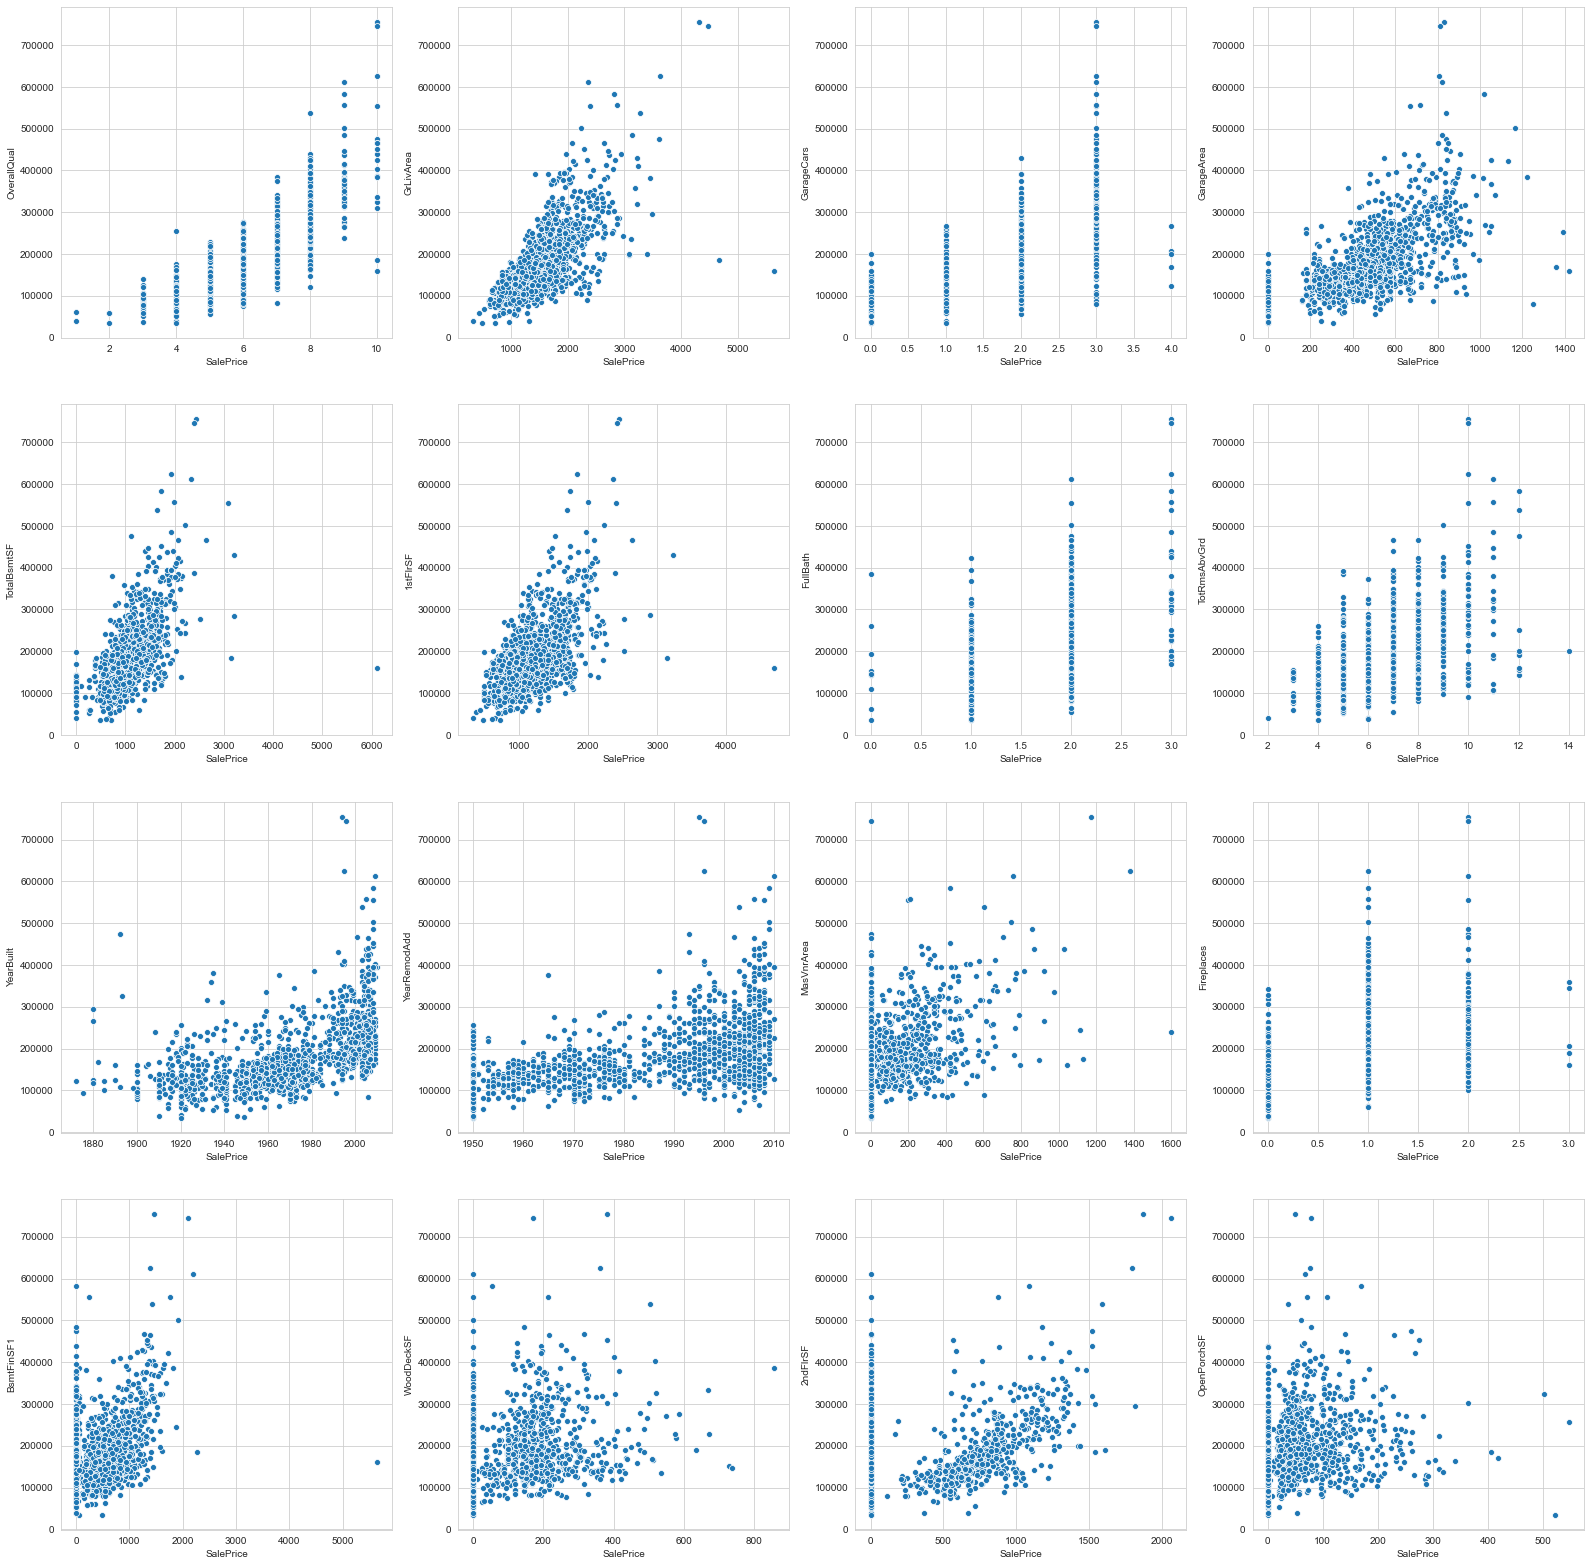

In [161]:
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
plt.subplots_adjust(right=1.3, top=1.3)
axs = axs.flatten()
for i, col in enumerate(list(df_train_corr.index[:16])):
    sns.scatterplot(y='SalePrice', x=col, ax=axs[i], data=df_train)
    axs[i].set_xlabel('SalePrice')
    axs[i].set_ylabel(col)
plt.show()

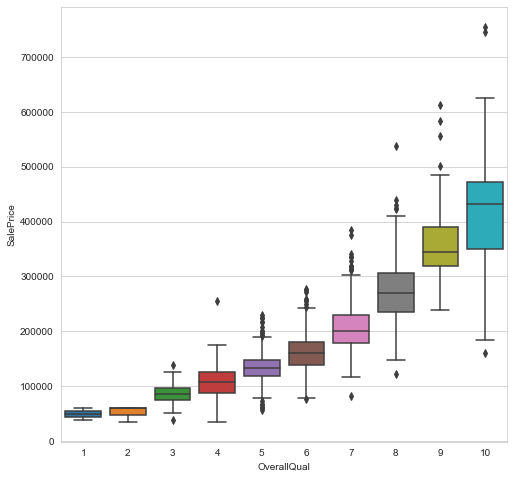

In [162]:
# Corr of "OverallQual": 0.7909
fig = plt.figure(figsize=(8, 8))
sns.boxplot(df_train['OverallQual'], df_train['SalePrice'])
plt.show()

OverallQual is a categorical data. The box plot show clearly the high correlation between Overall quality of the house with the its price.

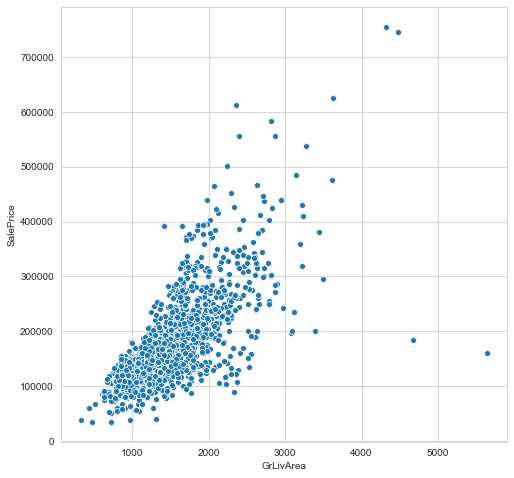

In [163]:
# Corr of "GrLivArea": 0.708
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice'])
plt.show()

## 1.3 Categorical features

In [164]:
df_train_cate = df_train.select_dtypes(include='object')
df_train_cate.head()

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub


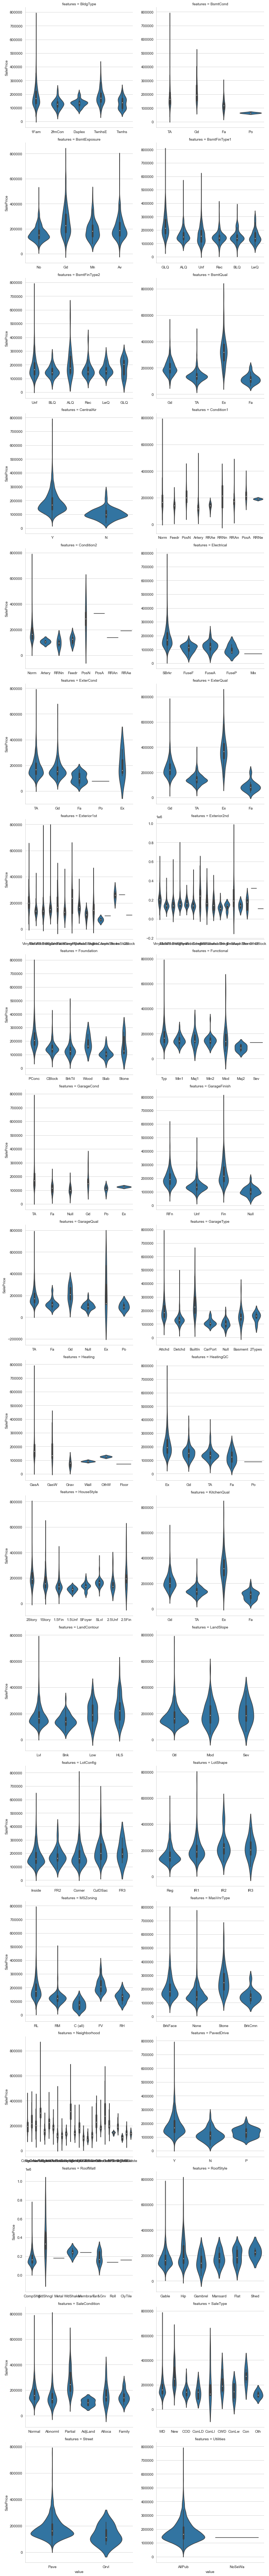

In [133]:
data = pd.melt(pd.concat([df_train_cate, y_train], axis=1),
               id_vars=['SalePrice'], value_vars=df_train_cate.columns, var_name='features')
g = sns.FacetGrid(data, col='features', col_wrap=2, sharex=False, sharey=False, size=5)
g.map(sns.violinplot, 'value', 'SalePrice')

# 2. Feature engineering

## Feature transformation

### Binning the "YearBuilt" & "YearRemodAdd" features

In [165]:
# Using binned technique for "YearBuilt", "YearRemodAdd" & "YrSold"
df_all['YearBuilt'] = pd.qcut(df_all['YearBuilt'], 10, duplicates='drop')
df_all['YearRemodAdd'] = pd.qcut(df_all['YearRemodAdd'], 10, duplicates='drop')
df_all['YrSold'] = pd.qcut(df_all['YrSold'], 10, duplicates='drop')

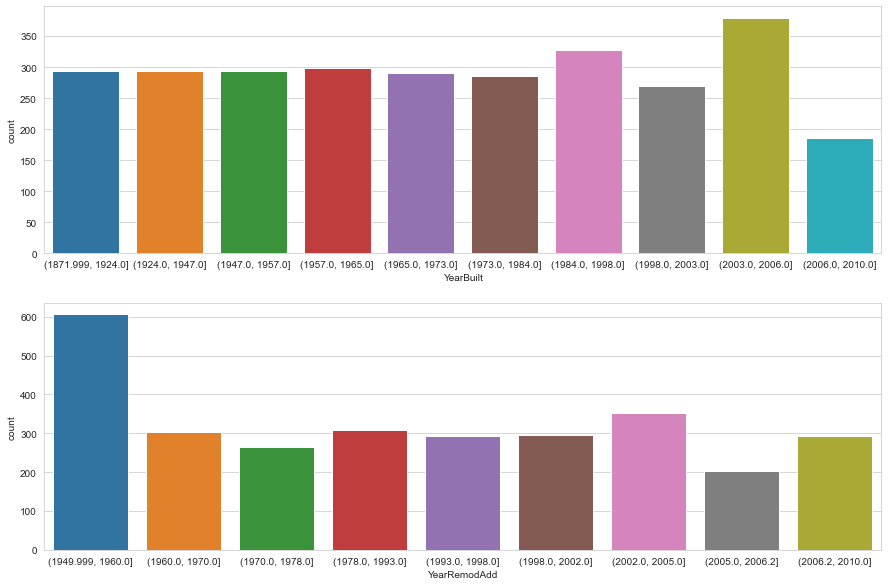

In [166]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
sns.countplot(df_all['YearBuilt'], ax=axs[0])
sns.countplot(df_all['YearRemodAdd'], ax=axs[1])
plt.show()

Transform some numeric features that are actually the categorical feature

In [167]:
# Transform numeric features that are really the categorical features
df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

### Generate some new useful features & Remove redundant ones

In [168]:
# Generating new features
# Total square foot
df_all['TotalSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

# Total number of bathroom
df_all['TotalBath'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))
df_all['TotalBsmtbath'] = df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath'])

# Total square feet of porch in a house
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                            df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

# Check the exist of each infrastructure (Ex: basement, bath,...) in a house
df_all['IsRemodel'] = df_all[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 1 if x[0] != x[1] else 0, axis=1)
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['Has2ndFloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasBsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [169]:
# Drop useles features
remove_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath',
              'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
df_all.drop(remove_cols, axis=1, inplace=True)

In [170]:
# List of categorical features
cate_cols = list(df_all.select_dtypes(include=['object', 'category']).columns)
# List of numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(df_all.select_dtypes(include=numeric_dtypes).columns)

### Label encoding

In [171]:
# Encode categorical features to numeric feature
for cate_col in cate_cols:
    df_all[cate_col] = preprocessing.LabelEncoder().fit_transform(df_all[cate_col].values)
    
# Checking whether encode all categorical features or not --> 0 (yes)
len(df_all.select_dtypes(include=['object', 'category']).columns)

0

In [172]:
df_train, df_test = divide_df(df_all)

## 2.2 Feature selection

### 2.2.1 Select categorical features
- Using **forward feature selection** to select the categorical features
- There are totally 30 numerical features, I'll use forward feature selection technique to select the most 20 appropriate feature with the target

In [115]:
# Step forward feature selection

from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(RandomForestRegressor(),
           k_features=20,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=3)
sfs1 = sfs1.fit(np.array(df_train[cate_cols]), np.array(y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   16.0s finished

[2021-08-13 17:09:02] Features: 1/20 -- score: 0.5329409194976842[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   18.1s finished

[2021-08-13 17:09:20] Features: 2/20 -- score: 0.632869353132583[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   19.9s finished

[2021-08-13 17:09:40] Features: 3/20 -- score: 0.6722354441536478[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [22]:
cate_features = list(df_train[cate_cols].columns[list(sfs1.k_feature_idx_)])
cate_features

NameError: name 'sfs1' is not defined

In [173]:
chosen_cate_features = ['BldgType',
 'BsmtExposure',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'Heating',
 'KitchenQual',
 'LandSlope',
 'MSSubClass',
 'MSZoning',
 'Neighborhood',
 'RoofMatl',
 'RoofStyle',
 'Street',
 'Utilities',
 'YearRemodAdd']

### 2.2.2 Select contunious features
Input: numeric features & Output: numerical feature
- Input features and the target are linear correlation

--> Using "Pearson coeficient" can be considered correctly

In [174]:
# Find feature correlation with target using pearson's coeficient
pearson = dict()
for col in num_cols:
    pear_val = stats.pearsonr(np.array(df_train[col]), np.array(y_train))[0]
    pearson[col] = pear_val
    
pearson = pd.Series(pearson).abs().sort_values(ascending=False)
# Choose only feature having correlation larger than 0.4
num_features = list(pearson.loc[pearson > 0.2].index)
num_features

['OverallQual',
 'GrLivArea',
 'TotalSF',
 'GarageCars',
 'TotalBath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'TotRmsAbvGrd',
 'MasVnrArea',
 'HasFireplace',
 'Fireplaces',
 'TotalPorchSF',
 '2ndFlrSF',
 'LotArea',
 'HasGarage',
 'TotalBsmtbath',
 'BsmtUnfSF']

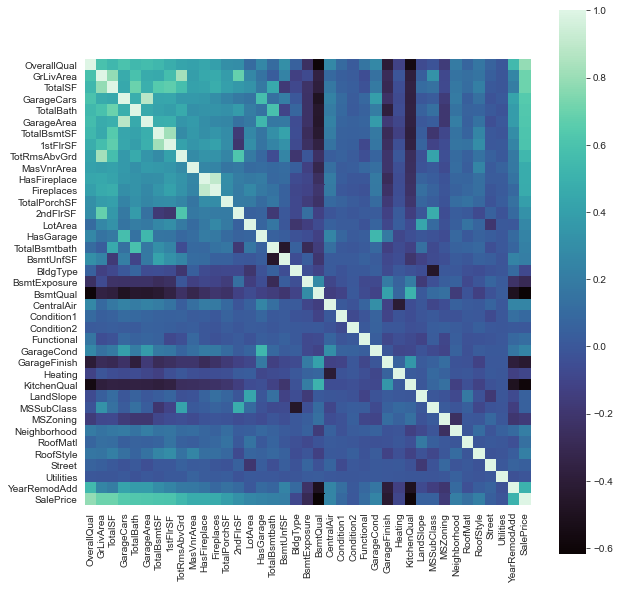

In [175]:
chosen_cols = num_features + chosen_cate_features

# Drawing the correlation table
fig = plt.figure(figsize=(10, 10))
sns.heatmap(pd.concat([df_train[chosen_cols], y_train], axis=1).corr(), square=True,
            cmap='mako', annot_kws={'size': 14})

In [176]:
df_train = df_train[chosen_cols]
df_test = df_test[chosen_cols]
df_all = concat_df(df_train, df_test)

## 2.3 Target transformation

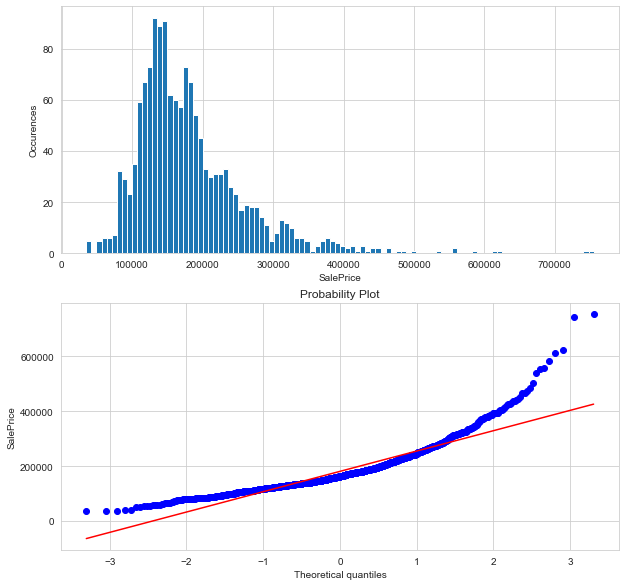

In [177]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

- Target feature is a heavy-tailed distribution --> Using Box-Cox transformation will bring the target from heavy-tailed to normal distribution
- SalePrice is a large scale feature, therefore it would be so problematic to take small-scale features to predict the SalePrice

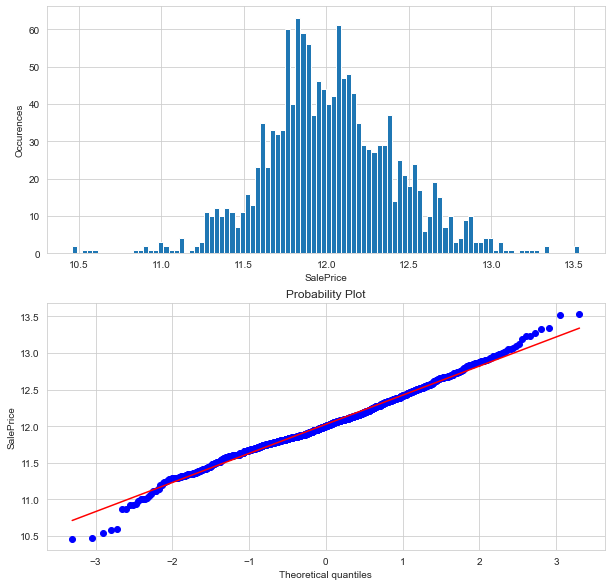

In [178]:
# Using Box-Cot transformation on target feature
org_y_train = y_train
y_train = pd.Series(stats.boxcox(y_train, lmbda=0), name='SalePrice')

# Visualize target after box-cox transformation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

**Skewness**
- Is the degree of distortion from the symmetrical normal curve --> Skewness of normal distribution is "0"
- **Positive skewness** means the tail on the right side of the distribution is longer and fatter
- **Negative skewness** means the tail on the left side of the ditribution is longer and fatter

**Kurtosis**
- In probability theory and statistics, **Kurtosis** is the measure of extreme values (outliers) presented in the distribution

In [179]:
# Compute Skewness & Kurtosis
print(f'Skewness before transformation: {stats.skew(org_y_train)}')
print(f'Kurtosis before transformation: {stats.kurtosis(org_y_train)}\n')

print(f'Skewness after transformation: {stats.skew(y_train)}')
print(f'Kurtosis after transformation: {stats.kurtosis(y_train)}')

Skewness before transformation: 1.880940746034036
Kurtosis before transformation: 6.509812011089439

Skewness after transformation: 0.1212103673013655
Kurtosis after transformation: 0.8026555069117713


## 2.4 Features transformation

Normalize the highly skewed numeric features

In [180]:
# Normalize skewness feature using Log function
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.75]
print(skew_features)           

# Apply Box cox for skewness > 0.75
for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

df_train, df_test = divide_df(df_all)

LotArea         12.822431
MasVnrArea       2.613592
TotalSF          1.835745
1stFlrSF         1.469604
TotalPorchSF     1.376649
GrLivArea        1.269358
TotalBsmtSF      1.162616
BsmtUnfSF        0.919703
2ndFlrSF         0.861675
TotRmsAbvGrd     0.758367
HasGarage       -3.955907
dtype: float64


Encode categorical features by one-hot encoding technique

In [181]:
df_train.shape

(1460, 38)

In [182]:
# Transform categorical feature to dummies features
encoded_features = list()

for df in [df_train, df_test]:
    for feature in chosen_cate_features:
        # Change to array after encoding b.c want to add columns when change back to df
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        # "n": Number of unique value in each feature
        n = df[feature].nunique()
        # "feature_uniqueVal" are the col's names in df after One-hot encoding
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(chosen_cate_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(chosen_cate_features):]], axis=1)

In [183]:
df_train.shape

(1460, 172)

In [184]:
df_all = concat_df(df_train, df_test)

(NOTE) pd.get_dummies() require object input not integer input

(NOTE) At this step we need to make sure # of features in training and testing data should be the same

# 3. Modeling

In [191]:
from sklearn.model_selection import RepeatedKFold # for repeated K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import datetime
SEED = 42

In [202]:
# Repeated K-fold cross validation
kfolds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)

# Return root mean square error of model prediction (Used for test prediction)
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Return root mean square error applied cross validation (Used for training prediction)
def evaluate_model(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

## Construct the stack model

In [221]:
def construct_models():
    # Initialize parameters for models
    alphas_ridge = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
    alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    e_alphas_elas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio_elas = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
    
    # Constructing the models
    models = dict()
    models['ridge'] = RidgeCV(alphas=alphas_ridge, cv=kfolds)
    models['lasso'] = LassoCV(alphas=alphas_lasso, random_state=SEED, cv=kfolds)
    models['elasticnet'] = ElasticNetCV(alphas=e_alphas_elas, cv=kfolds, l1_ratio=e_l1ratio_elas)
    models['svr'] = SVR(C = 20, epsilon = 0.008, gamma =0.0003)
    models['gbr'] = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10, 
                                              loss='huber',random_state =SEED) 
    models['lgbm'] = LGBMRegressor(objective='regression', num_leaves=4,
                                   learning_rate=0.01, n_estimators=5000,
                                   max_bin=200, bagging_fraction=0.75,
                                   bagging_freq=5, bagging_seed=7,
                                   feature_fraction=0.2,
                                   feature_fraction_seed=7, verbose=-1)
    models['xgboost'] = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7, verbosity = 0,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)
    # Construct stacking model
    models['stack_model'] = StackingCVRegressor(regressors=(models['ridge'], models['lasso'], 
                                                            models['elasticnet'], models['gbr'], models['svr'], 
                                                            models['lgbm']),
                                      meta_regressor=models['xgboost'], use_features_in_secondary=True)
    return models

In [222]:
# Construct the set of model
models = construct_models()

- Note for the reason why using np.array instead of dataframe for training
- Also note that this step compute rmse using cross validation technique

In [223]:
cv_rmse_result = dict()
cv_rmse_mean = dict()
cv_rmse_std = dict()

for name, model in models.items():
    cv_rmse_result[name] = evaluate_model(model, np.array(df_train), np.array(y_train))
    cv_rmse_mean[name] = cv_rmse_result[name].mean()
    cv_rmse_std[name] = cv_rmse_result[name].std()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [224]:
ML_cv = pd.DataFrame({'cv_rsme_mean' : cv_rmse_mean, 'cv_rmse_std' : cv_rmse_std})
ML_cv

,cv_rsme_mean,cv_rmse_std
ridge,0.128634,0.022520
lasso,0.128897,0.023262
elasticnet,0.128779,0.023244
svr,0.155248,0.019859
gbr,0.129382,0.019389
lgbm,0.128777,0.016521
xgboost,0.123219,0.018954
stack_model,0.124841,0.018271


Fitting data for training the model

In [225]:
# Training all the setting models with training data "df_train"
for name, model in models.items():
    model = model.fit(np.array(df_train), np.array(y_train))
    rmse_result = rmse(y_train, model.predict(np.array(df_train)))
    print(f'{name}\'s rmse after training: {rmse_result}\n')

ridge's rmse after training: 0.11457278491492287

lasso's rmse after training: 0.11255818081600555

elasticnet's rmse after training: 0.11349955088357101

svr's rmse after training: 0.09569062360854466

gbr's rmse after training: 0.059612905059175554

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
lgbm's rmse after training: 0.09235731068584802

xgboost's rmse after training: 0.06057737587809396

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample

## Blending model
- Combine the model above using blending technique

In [230]:
def blend_models_predict(X):
    return ((0.1 * models['ridge'].predict(X)) + \
            (0.1 * models['lasso'].predict(X)) + \
            (0.1 * models['elasticnet'].predict(X)) + \
            (0.12 * models['svr'].predict(X)) + \
            (0.17 * models['gbr'].predict(X)) + \
            (0.12 * models['lgbm'].predict(X)) + \
            (0.15 * models['xgboost'].predict(X)) + \
            (0.14 * models['stack_model'].predict(np.array(X))))

In [231]:
print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(np.array(df_train))))

RMSLE score on train data:
0.07748380184907515


In [232]:
id_val

0          1
1          2
2          3
3          4
4          5
        ... 
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1460, dtype: int64

In [233]:
blend_models_predict(df_test).shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 172 is different from 163)

In [234]:
df_test.shape

(1459, 163)

In [235]:
df_train.shape

(1460, 172)